In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import bz2
import os

# Any results you write to the current directory are saved as output.


In [2]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))


The scikit-learn version is 0.22.2.post1.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# File reading

In [4]:
trainfile = bz2.BZ2File('/content/drive/MyDrive/DLA/train.ft.txt.bz2','r')
lines = trainfile.readlines()

In [5]:
lines[1]

b"__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.\n"

In [6]:
docSentimentList=[]
def getDocumentSentimentList(docs,splitStr='__label__'):
    for i in range(len(docs)):
        #print('Processing doc ',i,' of ',len(docs))
        text=str(lines[i])
        #print(text)
        splitText=text.split(splitStr)
        secHalf=splitText[1]
        text=secHalf[2:len(secHalf)-1]
        sentiment=secHalf[0]
        #print('First half:',secHalf[0],'\nsecond half:',secHalf[2:len(secHalf)-1])
        docSentimentList.append([text,sentiment])
    print('Done!!')
    return docSentimentList

In [7]:
docSentimentList=getDocumentSentimentList(lines[:1000000],splitStr='__label__')

Done!!


In [8]:
train_df = pd.DataFrame(docSentimentList,columns=['Text','Sentiment'])
train_df.head()

,Text,Sentiment
0,Stuning even for the non-gamer: This sound tra...,2
1,The best soundtrack ever to anything.: I'm rea...,2
2,Amazing!: This soundtrack is my favorite music...,2
3,Excellent Soundtrack: I truly like this soundt...,2
4,"Remember, Pull Your Jaw Off The Floor After He...",2


In [9]:
train_df['Sentiment'][train_df['Sentiment']=='1'] = 0
train_df['Sentiment'][train_df['Sentiment']=='2'] = 1

In [10]:
train_df['word_count'] = train_df['Text'].str.lower().str.split().apply(len)
train_df.head()

,Text,Sentiment,word_count
0,Stuning even for the non-gamer: This sound tra...,1,80
1,The best soundtrack ever to anything.: I'm rea...,1,97
2,Amazing!: This soundtrack is my favorite music...,1,129
3,Excellent Soundtrack: I truly like this soundt...,1,118
4,"Remember, Pull Your Jaw Off The Floor After He...",1,87


# Data composition and visualization

In [ ]:
train_df['Sentiment'].value_counts()

1    505678
0    494322
Name: Sentiment, dtype: int64

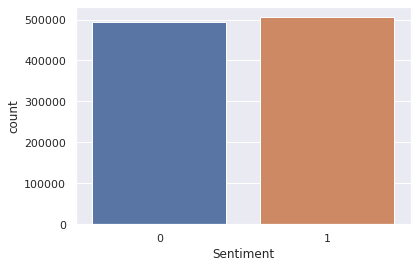

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")
sns.countplot(x="Sentiment", data=train_df)

Text(0.5, 0, 'Word count')

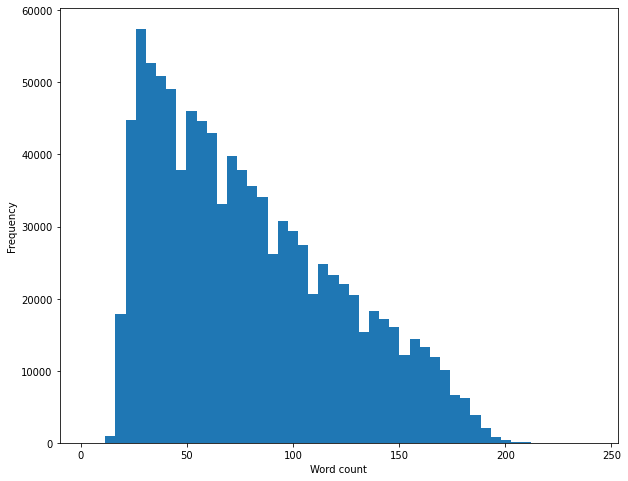

In [116]:
train_df['word_count'].plot(bins=50, kind='hist',figsize = (10,8)).set_xlabel("Word count")


# Text preprocessing


In [11]:
import string 
import re
def remove_punc(s):
    table = str.maketrans({key: None for key in string.punctuation})
    return s.translate(table)
def remove_url(text):
     url=re.compile(r"https?://\S+|www\.\S+")
     return url.sub(r" ",text)

def remove_html(text):
  cleanr = re.compile('<.*?>')
  return cleanr.sub(r" ",text)

def remove_num(text):
   output = re.sub(r'\d+', '', text)
   return output

In [12]:
train_df['Text'] = train_df['Text'].apply(remove_punc)
train_df['Text'] = train_df['Text'].apply(remove_html)
train_df['Text'] = train_df['Text'].apply(remove_url)
train_df['Text'] = train_df['Text'].apply(remove_num)

train_df.shape

(1000000, 3)

In [13]:
train_df.head()

,Text,Sentiment,word_count
0,Stuning even for the nongamer This sound track...,1,80
1,The best soundtrack ever to anything Im readin...,1,97
2,Amazing This soundtrack is my favorite music o...,1,129
3,Excellent Soundtrack I truly like this soundtr...,1,118
4,Remember Pull Your Jaw Off The Floor After Hea...,1,87


In [14]:
len(train_df['word_count'][train_df['word_count']<=25])

63720

In [15]:
train_df1 = train_df[:][train_df['word_count']<=25]
train_df1.head()

,Text,Sentiment,word_count
44,autumn got this for my daughter in NC she is n...,1,22
58,Hunting the Hard Way Thia was a gift for my Hu...,1,25
77,Smells divine This is my second bottle of shee...,1,25
78,Very disappointed This perfume is just AWFUL S...,0,24
99,Caution These tracks are not the original vers...,0,22


In [16]:
train_df1['Sentiment'].value_counts()

1    39932
0    23788
Name: Sentiment, dtype: int64

In [17]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
st_wd = text.ENGLISH_STOP_WORDS
c_vector = CountVectorizer(stop_words = st_wd,min_df=.0001,lowercase=1)
c_vector.fit(train_df1['Text'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=1, max_df=1.0, max_features=None, min_df=0.0001,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}),
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [18]:
word_list = list(c_vector.vocabulary_.keys())
stop_words = list(c_vector.stop_words) 

In [19]:
len(stop_words),len(word_list)

(318, 8805)

In [20]:
def remove_words(raw_sen,stop_words):
    sen = [w for w in raw_sen if w not in stop_words]
    return sen

In [29]:
def reviewEdit(raw_sen_list,stop_words):
    sen_list = []
    for i in range(len(raw_sen_list)):
        raw_sen = raw_sen_list[i].split()
        sen_list.append(remove_words(raw_sen,stop_words))
    return sen_list

In [30]:
sen_list = reviewEdit(list(train_df1['Text']),stop_words)

In [67]:
#BERT TEST
#!pip install transformers
#from transformers import AutoTokenizer, TFAutoModel, AutoConfig, AutoModel, AutoModelForMaskedLM
#config = AutoConfig.from_pretrained('bert-base-uncased', hidden_size=100)
#config 
#tokenizer = AutoTokenizer.from_pretrained("distilroberta-base", add_prefix_space=True)
#model = TFAutoModel.from_pretrained("distilroberta-base")
#inputs = tokenizer(sen_list, max_length=25, truncation=True, padding=True, is_split_into_words=True, return_tensors="tf")
#outputs = model(**inputs)

Some layers from the model checkpoint at distilroberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


ResourceExhaustedError: ignored

In [31]:
from gensim.models import fasttext
ft_model = fasttext.FastText(sen_list,size=100)

In [37]:
ft_model.wv.most_similar("beutiful")

[('beautiful', 0.9853143692016602),
 ('Beautifuln', 0.9836337566375732),
 ('beautifuln', 0.9824850559234619),
 ('Beautiful', 0.9787737131118774),
 ('beautifull', 0.9720891714096069),
 ('beautifullyn', 0.9621118307113647),
 ('beautifully', 0.9471719264984131),
 ('Beautifully', 0.9436919093132019),
 ('beatiful', 0.9338065385818481),
 ('Powerful', 0.9276737570762634)]

In [24]:
ft_model.wv.syn0.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


(14196, 100)

In [36]:
from sklearn.model_selection import train_test_split
def getEmbedding3D(sen_list,wv_model):
    word_set = set(wv_model.wv.index2word)
    X = np.zeros([len(sen_list),25,100])
    c = 0
    for sen in sen_list:
        nw=24
        for w in list(reversed(sen)):
            if w in word_set:
                X[c,nw] = wv_model[w]
                nw=nw-1
        c=c+1
    return X

In [37]:
X_ANN = getEmbedding3D(sen_list,ft_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [38]:
y = train_df1['Sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X_ANN, y, test_size=0.1, random_state=42)
y_train = y_train.astype('bool')
y_test = y_test.astype('bool')

In [39]:
np.save("/content/drive/MyDrive/DLA/test_X_ANN", X_test, allow_pickle=True, fix_imports=True)
np.save("/content/drive/MyDrive/DLA/y_test_ANN", y_test, allow_pickle=True, fix_imports=True)

In [40]:
def get_embedding2D(sen_list,wv_model):
    word_set = set(wv_model.wv.index2word)
    X = np.zeros([len(sen_list),100])
    c = 0
    for sen in sen_list:
        nw=24
        for w in list(reversed(sen)):
            if w in word_set:
                X[c] = wv_model[w]
                nw=nw-1
        c=c+1
    return X

In [41]:
X_baseline = get_embedding2D(sen_list,ft_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [71]:
y = train_df1['Sentiment'].values
X_trainBaseline, X_testBaseline, y_trainBaseline, y_testBaseline = train_test_split(X_baseline, y, test_size=0.1, random_state=42)
y_trainBaseline = y_trainBaseline.astype('bool')
y_testBaseline = y_testBaseline.astype('bool')


In [ ]:
np.save("/content/drive/MyDrive/DLA/test_X_baseline", X_testBaseline, allow_pickle=True, fix_imports=True)
np.save("/content/drive/MyDrive/DLA/y_test_baseline", y_testBaseline, allow_pickle=True, fix_imports=True)

In [127]:
# Baseline models

# Baseline models

In [80]:
from sklearn import svm
start_time = time.time()
svm = svm.SVC()
svm.fit(X_trainBaseline, y_trainBaseline)
print("Training time: %s seconds" % (time.time() - start_time))


Training time: 429.50916624069214


In [74]:
from sklearn.metrics import accuracy_score

In [81]:
start_time = time.time()
y_pred = svm.predict(X_testBaseline)
print("Prediction time for the test set: %s seconds" % (time.time() - start_time))

Prediction time for the test set: 28.813615560531616 seconds


In [82]:
accuracy_score(y_test, y_pred)

0.7780916509730069

In [110]:
from sklearn.ensemble import RandomForestClassifier
start_time = time.time()
RF = RandomForestClassifier(max_depth=500, random_state=0)
RF.fit(X_trainBaseline, y_trainBaseline)
print("Training time: %s s" % (time.time() - start_time))


Training time: 24.73552680015564 s


In [111]:
start_time = time.time()
y_pred = RF.predict(X_testBaseline)
print("Prediction time for the test set: %s" % (time.time() - start_time))

Prediction time for the test set: 0.1316542625427246


In [112]:
accuracy_score(y_test, y_pred)

0.7940991839296924

In [113]:
from joblib import dump, load
dump(svm, '/content/drive/MyDrive/DLA/svm.joblib') 
dump(RF, '/content/drive/MyDrive/DLA/randomforest.joblib') 

['/content/drive/MyDrive/DLA/randomforest.joblib']

# BDRNN train

In [42]:
import keras.backend as K
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation,LSTM, SimpleRNN ,GRU , Bidirectional,Input ,Concatenate, Multiply,Lambda,Reshape
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## BDNN LSTM

In [43]:
input_st  = Input(shape=(25,100))
lstm1 = Bidirectional(LSTM(200,input_shape=(25,100),activation='relu',return_sequences=True),merge_mode='mul')(input_st)
lstm2 = Bidirectional(LSTM(1,input_shape=(25,100),activation='relu',return_sequences=True),merge_mode='mul')(lstm1)
lstm2 = Activation('sigmoid')(lstm2)

dense = Dense(100,activation='relu')(lstm2)
output = Dense(1,activation='sigmoid')(dense)

model = Model(inputs=input_st, outputs=output)
print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 25, 100)]         0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 25, 200)           481600    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 25, 1)             1616      
_________________________________________________________________
activation_1 (Activation)    (None, 25, 1)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 25, 100)           200       
_________________________________________________________________
dense_5 (Dense)              (None, 25, 1)             101       
Total params: 483,517
Trainable params: 483,517
Non-trainable params: 0
_____________________________________________________

In [44]:
start_time = time.time()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
hist = model.fit(X_train,y_train,validation_split=0.1,
          epochs=10, batch_size=512)
print("Training time BDRNN LSTM: %s seconds" % (time.time() - start_time))


Epoch 1/10
101/101 [==============================] - 17s 115ms/step - loss: 0.6854 - accuracy: 0.5306 - val_loss: 0.6578 - val_accuracy: 0.6323
Epoch 2/10
101/101 [==============================] - 11s 109ms/step - loss: 0.6624 - accuracy: 0.6234 - val_loss: 0.6578 - val_accuracy: 0.6323
Epoch 3/10
101/101 [==============================] - 11s 108ms/step - loss: 0.6621 - accuracy: 0.6241 - val_loss: 0.6577 - val_accuracy: 0.6323
Epoch 4/10
101/101 [==============================] - 11s 108ms/step - loss: 0.6360 - accuracy: 0.6225 - val_loss: 0.5661 - val_accuracy: 0.6323
Epoch 5/10
101/101 [==============================] - 11s 109ms/step - loss: 0.5497 - accuracy: 0.6308 - val_loss: 0.4852 - val_accuracy: 0.7904
Epoch 6/10
101/101 [==============================] - 11s 109ms/step - loss: 0.4687 - accuracy: 0.8059 - val_loss: 0.4164 - val_accuracy: 0.8536
Epoch 7/10
101/101 [==============================] - 11s 110ms/step - loss: 0.3978 - accuracy: 0.8581 - val_loss: 0.3810 - val_ac

In [45]:
y_test = y_test.astype('bool')
model.evaluate(X_test, y_test, batch_size=64)

100/100 [==============================] - 1s 12ms/step - loss: 0.3136 - accuracy: 0.8810


[0.3136191964149475, 0.881004273891449]

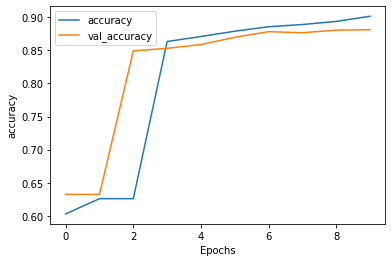

In [105]:
plot_graphs(hist, "accuracy")

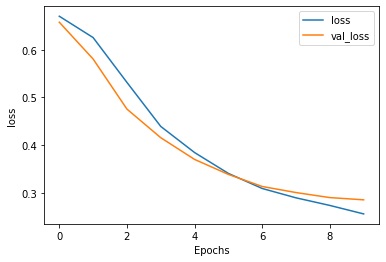

In [106]:
plot_graphs(hist, "loss")

In [46]:
model.save("/content/drive/MyDrive/DLA/BidirectionalLSTM")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DLA/BidirectionalLSTM/assets


In [47]:
del model

##BDNN GRU

In [48]:
input_st  = Input(shape=(25,100))
lstm1 = Bidirectional(GRU(200,input_shape=(25,100),activation='relu',return_sequences=True),merge_mode='mul')(input_st)
lstm2 = Bidirectional(GRU(1,input_shape=(25,100),activation='relu',return_sequences=True),merge_mode='mul')(lstm1)
dense = Dense(100,activation='relu')(lstm2)
output = Dense(1,activation='sigmoid')(dense)

model = Model(inputs=input_st, outputs=output)
print(model.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 25, 100)]         0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 25, 200)           362400    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 25, 1)             1218      
_________________________________________________________________
dense_6 (Dense)              (None, 25, 100)           200       
_________________________________________________________________
dense_7 (Dense)              (None, 25, 1)             101       
Total params: 363,919
Trainable params: 363,919
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
start_time = time.time()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
hist = model.fit(X_train,y_train,validation_split=0.1,
          epochs=10, batch_size=512)
print("Training time BDRNN GRU: %s seconds" % (time.time() - start_time))


Epoch 1/10
101/101 [==============================] - 18s 145ms/step - loss: 0.5918 - accuracy: 0.6318 - val_loss: 0.4254 - val_accuracy: 0.8554
Epoch 2/10
101/101 [==============================] - 14s 138ms/step - loss: 0.4199 - accuracy: 0.8609 - val_loss: 0.4015 - val_accuracy: 0.8657
Epoch 3/10
101/101 [==============================] - 14s 138ms/step - loss: 0.3926 - accuracy: 0.8739 - val_loss: 0.3834 - val_accuracy: 0.8726
Epoch 4/10
101/101 [==============================] - 14s 138ms/step - loss: 0.3807 - accuracy: 0.8779 - val_loss: 0.3734 - val_accuracy: 0.8754
Epoch 5/10
101/101 [==============================] - 14s 139ms/step - loss: 0.3589 - accuracy: 0.8859 - val_loss: 0.3760 - val_accuracy: 0.8711
Epoch 6/10
101/101 [==============================] - 14s 137ms/step - loss: 0.3506 - accuracy: 0.8856 - val_loss: 0.3541 - val_accuracy: 0.8732
Epoch 7/10
101/101 [==============================] - 14s 138ms/step - loss: 0.3305 - accuracy: 0.8942 - val_loss: 0.3489 - val_ac

In [50]:
model.evaluate(X_test, y_test, batch_size=64)

100/100 [==============================] - 2s 15ms/step - loss: 0.3148 - accuracy: 0.8954


[0.3148319721221924, 0.8953734636306763]

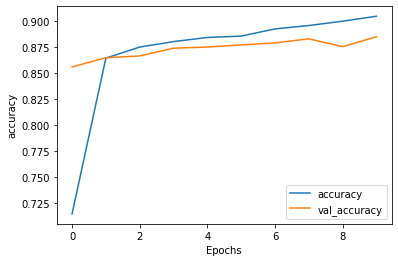

In [121]:
plot_graphs(hist, "accuracy")

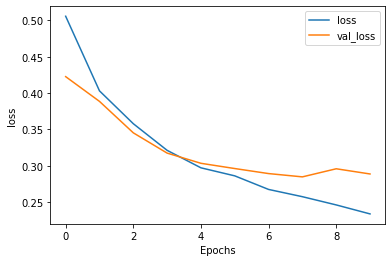

In [122]:
plot_graphs(hist, "loss")

In [51]:
model.save("/content/drive/MyDrive/DLA/BidirectionalGRU")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DLA/BidirectionalGRU/assets


In [ ]:
del model